In [46]:
%pylab inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import sys
sys.path.append("../subjective-fits/")
import seaborn as sns
figsize(8,6)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


//anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [55]:
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

# Comparing approaches to subjective probability and statistics

We illustrate various approaches to statistics based on subjective probability. Our test case is the estimation of the mean of a one-dimensional Gaussian, both using a point estimate and an "uncertainty" interval. Both the mathematical guarantees as well as the interpretation of these two outputs differ for each approach, we will comment on that.

The setting is $x_1,\dots,x_N\sim\mathcal{N}(\mu,\sigma^2)$, with $\sigma^2$ known. The statistician's goal is to infer $\mu$.

In [56]:
def generateData(N, mu, sigma2, tag="well-specified"):
    if tag=="well-specified":
        return mu+np.sqrt(sigma2)*npr.randn(N)

In [62]:
npr.seed(1)
muTrue = 1
sigma2True = 1
alpha = .05
gamma = 1 # importance of the length of the interval vs. the interval containing the true value
N = 100
x = generateData(N, muTrue, sigma2True)

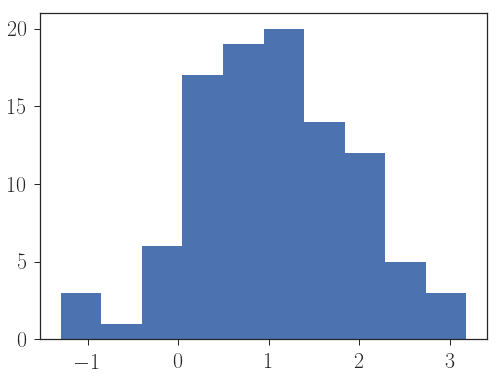

In [63]:
plt.hist(x)
plt.show()

## Conjugate Bayes

TODO: Describe here the Bayesian approach, including the cost function

In [64]:
import ConjugateBayes as cb
cb = cb.ConjugateBayes(data=x, sigma2Lhd=sigma2True**2, muPrior=10, sigma2Prior=10)
print(cb.estimate())
print(cb.interval(1-alpha))
print(np.mean(cb.interval(1-alpha))==cb.estimate())

1.0695133387369615
(0.8736148650447291, 1.265411812429194)
True


Now among centered intervals, I want to pick the one with the best integrated cost 
$$\int \left(\gamma \vert I\vert + 1_{\theta\notin I}\right) p(\theta\vert x)d\theta = \gamma \vert I\vert + \alpha$$

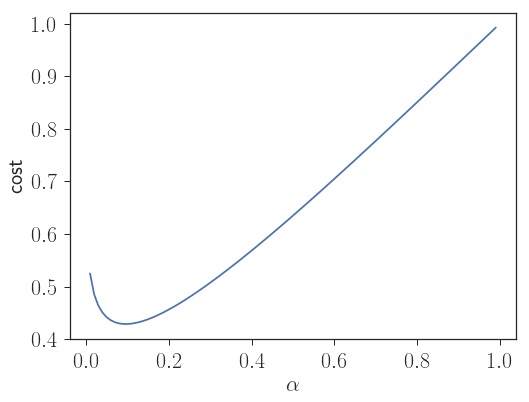

In [65]:
alphas = np.linspace(0.01,.99, 100)
costs = []
for alpha  in alphas:
    lo, hi = cb.interval(1-alpha)
    costs.append( gamma*(hi-lo) + alpha )

plt.plot(alphas, costs)
plt.xlabel(r"$\alpha$")
plt.ylabel("cost")
plt.show()

The Bayes action is to report the credible interval with $\alpha$ set to the minizer of this curve!